In [34]:
import matplotlib.pyplot as plt
import math
from scipy.spatial import ConvexHull
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [60]:

# Alur umum dari program :
# Diterima sebuah tuple berisikan koordinat (x dan y) dari titik-titik data
# Koordinat diubah menjadi 1 instance dari class Coordinates, dan diappend ke dalam List of Coordinates bernama CoordinatesList
# CoordinatesList diurutkan berdasarkan kenaikan absis, bila ada dua koordinat dengan absis yang sama, urutan ditentukan oleh kenaikan ordinat
# Mengambil titik minimum (CoordinatesList[0]) dan maksimum (CoordinatesList[len(CoordinatesList) - 1])
# Append titik minimum dan maksimum dari CoordinatesList ke dalam sebuah list ConvexEdgesList
# Membagi semua titik yang tersisa ke dalam 3 kelompok, pada garis pembatas, di atas/kiri garis pembatas, dan di bawah/kanan garis pembatas
# Posisi titik yang tersisa dapat ditentukan dengan menggunakan determinan
# Determinan > 0 : Titik berada pada atas/kiri pembatas, masuk ke dalam list LeftCoordinatesList
# Determinan = 0 : Titik berada pada pembatas, diabaikan
# Determinan < 0 : Titik berada pada bawah/kanan pembatas, masuk ke dalam list RightCoordinatesList
# Dari LeftCoordinatesList, dicari titik dengan jarak maksimum. Simpan sebagai LeftMax dan append ke ConvexEdgesList
# Dari RightCoordinatesList, dicari titik dengan jarak maksimum. Simpan sebagai RightMax dan append ke ConvexEdgesList
# Start rekursi : 
# Hubungkan titik awal dengan titik LeftMax/RightMax. Cari titik maks baru yang di luar garis pembatas

class Coordinates:
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Mengurutkan semua koordinat berdasarkan kenaikan absisnya. Bila ada dua titik dengan absis yang sama, diurutkan berdasarkan kenaikan absisnya.
def sortList(CoordinatesList):
    # untuk melakukan sorting semua koordinat berdasarkan absis yang menaik
    # sorting dilakukan dengan menggunakan selection sort (diimplementasikan dengan dasar algoritma Divide and Conquer)
    for i in range(0, len(CoordinatesList)):
        toBeSwitchedIndex = i
        for j in range(i+1, len(CoordinatesList)):
            if CoordinatesList[j].x < CoordinatesList[toBeSwitchedIndex].x:
                toBeSwitchedIndex = j
        CoordinatesList[i], CoordinatesList[toBeSwitchedIndex] = CoordinatesList[toBeSwitchedIndex], CoordinatesList[i]
    isNotSorted = True
    while isNotSorted:
        swapCount = 0
        for i in range(0, len(CoordinatesList) - 1):
            if ((CoordinatesList[i].x == CoordinatesList[i+1].x) and (CoordinatesList[i].y > CoordinatesList[i + 1].y)):
                swapCount += 1
                CoordinatesList[i], CoordinatesList[i + 1] = CoordinatesList[i + 1], CoordinatesList[i]
        if swapCount == 0:
            isNotSorted = False
    # for i in CoordinatesList:
    #     print(i.x, " ", i.y) 
    return CoordinatesList

# Membagi semua titik yang tersisa menjadi dua bagian, LeftCoordinatesList dan RightCoordinatesList, berdasarkan nilai determinannya
def splitByDeterminant(start, end, CoordinatesList, LeftCoordinatesList, RightCoordinatesList):
    while (len(CoordinatesList) > 0):
        var = CoordinatesList[0]
        value = determinant(start, var, end)
        if value < 0: 
            CoordinatesList.pop(0)
            RightCoordinatesList.append(var)
        elif value > 0:
            CoordinatesList.pop(0)
            LeftCoordinatesList.append(var)
        else:
            CoordinatesList.pop(0)
    return LeftCoordinatesList, RightCoordinatesList

# Mengembalikan nilai determinan untuk menentukan posisi sebuah titik di atas, di bawah, atau pada garis start-end
def determinant(start, var, end):
    if start is None:
        return 0
    elif var is None:
        return 0
    elif end is None:
        return 0
    else:
        value = start.x * end.y + var.x * start.y + end.x * var.y - var.x * end.y - end.x * start.y - start.x * var.y
        return value 

def measureAngle(start, var, end):
    startToVar = [var.x - start.x, var.y - start.y]
    varToEnd = [end.x - var.x, end.y - var.y]
    dotProduct = np.dot(startToVar, varToEnd)
    if not(abs(dotProduct) > 1):
        tempAngle = np.arccos(dotProduct)
    else:
        tempAngle = 90
    return tempAngle

def isThereOuterConvexEdge(start, end, CoordinatesList, upperConvexHull):
    count = 0
    for var in CoordinatesList:
        if var is not None:
            value = determinant(start, var, end)
            if (upperConvexHull):
                if (value > 0):
                    count += 1
            else:
                if (value < 0):
                    count += 1
    return count

def isOutsideInsideLine(start, var, end, isOutside):
    if isOutside:
        return (determinant(start, var, end) > 0)
    else:
        return (determinant(start, var, end) < 0)

# Menerima input origin (LeftCoordinatesList atau RightCoordinatesList), variableList (list origin yang sudah dikurang-kurangi dari aturan determinan),
#   startList (berisikan list Coordinates dari startEdge sampai tengah titik), tempList (berisikan list Coordinates dari tengah ke kiri/kanan), 
#   endList (berisikan list Coordinates sampai endEdge), leftDone (boolean yang menunjukkan bila bagian kiri sudah diproses), 
#   dan hasStartRecursive (boolean yang menunjukkan sudah atau belumnya dimulai proses recursive)
# Mengembalikan list Coordinates dari startEdge hingga endEdge
# Proses dimulai dengan iterasi dari startEdge hingga middleEdge (penamaan saja). lalu rekursif hingga didapatkan semua Coordinates
# Lalu dilanjutkan dengan mencari semua Coordinates dari middleEdge hingga endEdge.
def recursiveConvexHull(origin, startList, tempList, endList, isUpper):
    # dia bakal cari dulu titik tengahnya, terus divide terus ke kiri
    # inisiasi jarakMax, sudutMax, titikMax sebagai None/negatif
    countFinish = isThereOuterConvexEdge(startList[-1], endList[0], origin, isUpper)
    if countFinish != 0:
        maxDistanceFromStartEnd = -1
        maxAngleFromStartEnd = -1
        maxPoint = None
        # s = start, e = end, m = gradien, c = constant
        s = startList[-1]
        if (len(tempList) == 0):
            e = endList[0]
        else:
            e = tempList[0]
        m = (e.y - s.y) / (e.x - s.x)
        c = s.y - m * s.x
        for var in origin:
            if (var not in startList) and (var not in endList) and (var not in tempList) and (isOutsideInsideLine(s, var, e, isUpper)):
                tempDistanceFromStartEnd = abs((m * var.x - var.y + c) / math.sqrt(m ** 2 + 1))
                if (tempDistanceFromStartEnd > maxDistanceFromStartEnd):
                    tempAngle = measureAngle(s,var,e)
                    maxDistanceFromStartEnd = tempDistanceFromStartEnd
                    maxAngleFromStartEnd = tempAngle
                    maxPoint = var
                elif (tempDistanceFromStartEnd == maxDistanceFromStartEnd):
                    tempAngle = measureAngle(s,var,e)
                    if (tempAngle > maxAngleFromStartEnd):
                        maxAngleFromStartEnd = tempAngle
                        maxPoint = var 
        tempList.insert(0,maxPoint)
        # untuk mengecek apakah ada titik di antara titik maks sebelumnya dengan titik awal yang merupakan convex edge
        count = 999
        if maxPoint is not None:
            count = isThereOuterConvexEdge(s, maxPoint, origin, isUpper)
        if count == 0 or maxPoint is None:
            newStartList = startList + tempList
            return recursiveConvexHull(origin, newStartList, [], endList, isUpper)
        else:
            return recursiveConvexHull(origin, startList, [maxPoint], endList, isUpper)
    else:
        return startList + endList


def createListForPlot(CoordinatesList):
    listX = []
    listY = []
    for i in range(len(CoordinatesList)):
        if CoordinatesList[i] != None:
            listX.append(CoordinatesList[i].x)
            listY.append(CoordinatesList[i].y)
    listCombine = [listX, listY]
    return listCombine

def myConvexHull(bucket):
    CoordinatesList = []
    LeftCoordinatesList = []
    RightCoordinatesList = []
    ConvexEdgesList = []
    for i in range(0, len(bucket)):
        CoordinatesList.append(Coordinates(bucket[i,0], bucket[i,1]))
    CoordinatesList = sortList(CoordinatesList)
    # PointA dan PointB adalah poin maksimum dan minimum sebagai ujung dari convex hull
    startEdge = CoordinatesList[0]
    endEdge = CoordinatesList[-1]
    # Bagi sisa titik berdasarkan nilai determinan
    copyCoordinatesList = CoordinatesList[:]
    LeftCoordinatesList, RightCoordinatesList = splitByDeterminant(startEdge, endEdge, copyCoordinatesList[1:-1], LeftCoordinatesList, RightCoordinatesList)
    LeftCoordinatesList = sortList(LeftCoordinatesList)
    RightCoordinatesList = sortList(RightCoordinatesList)
    upLeftConvexEdges = recursiveConvexHull(LeftCoordinatesList, [startEdge], [], [endEdge], True)
    downRightConvexEdges = recursiveConvexHull(RightCoordinatesList, [startEdge], [], [endEdge], False)
    return upLeftConvexEdges, downRightConvexEdges, CoordinatesList
    

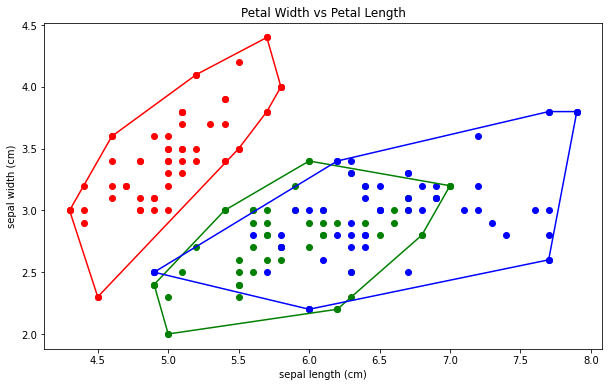

In [61]:
plt.figure(figsize = (10, 6))
colors = ['r', 'g', 'b']

plt.title('Petal Width vs Petal Length')

data = datasets.load_iris()
df = pd.DataFrame(data.data, columns = data.feature_names)
df['Target'] = pd.DataFrame(data.target)

plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])

for i in range(0,3): # tadi diedit dari length(data.target_names)
    bucket = df[df['Target'] == i].iloc[:, [2, 3]].values
    up, down, all = myConvexHull(bucket)
    hullDown = createListForPlot(down)
    plt.scatter(hullDown[0], hullDown[1], color = colors[i])
    plt.plot(hullDown[0], hullDown[1], color = colors[i])
    hullUp = createListForPlot(up)
    plt.scatter(hullUp[0], hullUp[1], color = colors[i])
    plt.plot(hullUp[0], hullUp[1], color = colors[i])
    listAll = createListForPlot(all)
    plt.scatter(listAll[0], listAll[1], color = colors[i])
plt.show()

Proses yang atas
ini ngecek s kedus 4.5 1.7
sekarang lagi nguji titik (4.8,1.8) dan jaraknya 0.024253562503633426
sekarang lagi nguji titik (4.8,1.8) dan jaraknya 0.024253562503633426
sekarang lagi nguji titik (4.9,1.8) dan jaraknya 0.0
sekarang lagi nguji titik (4.9,1.8) dan jaraknya 0.0
sekarang lagi nguji titik (4.9,2.0) dan jaraknya 0.19402850002906633
sekarang lagi nguji titik (5.0,1.9) dan jaraknya 0.07276068751089985
sekarang lagi nguji titik (5.0,2.0) dan jaraknya 0.16977493752543313
sekarang lagi nguji titik (5.1,1.9) dan jaraknya 0.04850712500726664
sekarang lagi nguji titik (5.1,1.9) dan jaraknya 0.04850712500726664
sekarang lagi nguji titik (5.1,2.0) dan jaraknya 0.1455213750217999
sekarang lagi nguji titik (5.1,2.3) dan jaraknya 0.4365641250653993
sekarang lagi nguji titik (5.1,2.4) dan jaraknya 0.5335783750799326
sekarang lagi nguji titik (5.2,2.0) dan jaraknya 0.12126781251816648
sekarang lagi nguji titik (5.2,2.3) dan jaraknya 0.4123105625617659
sekarang lagi nguji titi

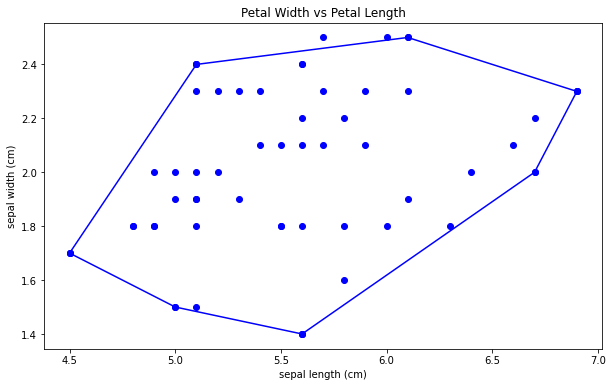

In [39]:
plt.figure(figsize = (10, 6))
colors = ['r', 'g', 'b']

plt.title('Petal Width vs Petal Length')

data = datasets.load_iris()
df = pd.DataFrame(data.data, columns = data.feature_names)
df['Target'] = pd.DataFrame(data.target)

plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])

for i in range(2,3): # tadi diedit dari length(data.target_names)
    bucket = df[df['Target'] == i].iloc[:, [2, 3]].values
    up, down, all = myConvexHull(bucket)
    hullDown = createListForPlot(down)
    plt.scatter(hullDown[0], hullDown[1], color = colors[i])
    plt.plot(hullDown[0], hullDown[1], color = colors[i])
    hullUp = createListForPlot(up)
    plt.scatter(hullUp[0], hullUp[1], color = colors[i])
    plt.plot(hullUp[0], hullUp[1], color = colors[i])
    listAll = createListForPlot(all)
    plt.scatter(listAll[0], listAll[1], color = colors[i])
plt.show()

[41 13]
[36 41]
[22 13]
[22 32]
[15 14]
[15 32]
[18 14]
[18 36]
 
[35  0]
[34  7]
[34 35]
[10  7]
[10 18]
[26  0]
[26 18]
 
[19  6]
[18 31]
[18 19]
[48  6]
[17 31]
[17 48]
 


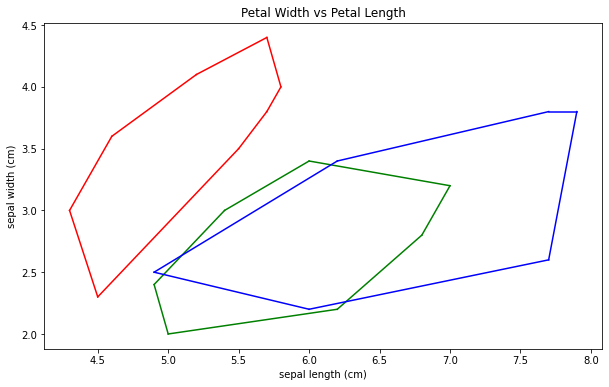

In [40]:
plt.figure(figsize = (10, 6))
colors = ['r', 'g', 'b']

plt.title('Petal Width vs Petal Length')

data = datasets.load_iris()
df = pd.DataFrame(data.data, columns = data.feature_names)
df['Target'] = pd.DataFrame(data.target)

plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])

for i in range(len(data.target_names)):
    bucket = df[df['Target'] == i].iloc[:, [0, 1]].values
    hull = ConvexHull(bucket)
    for simplex in hull.simplices:
        print(simplex)
        plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[i])
    print(" ")
plt.show()

[10  9]
[ 1 13]
[1 0]
[17  9]
[17  0]
[16 13]
[16 10]
 
[10  9]
[ 1 13]
[1 0]
[17  9]
[17  0]
[16 13]
[16 10]
 
[10  9]
[ 1 13]
[1 0]
[17  9]
[17  0]
[16 13]
[16 10]
 


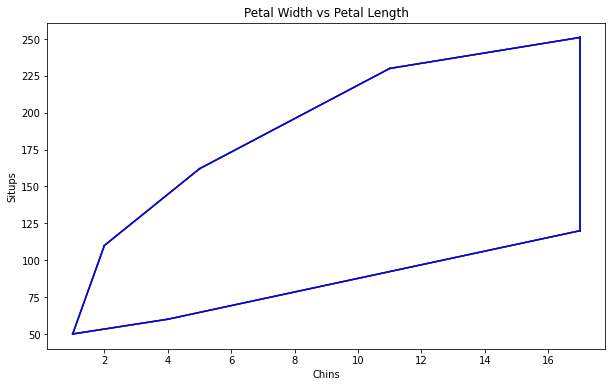

In [41]:
plt.figure(figsize = (10, 6))
colors = ['r', 'g', 'b']

plt.title('Petal Width vs Petal Length')

data = datasets.load_linnerud()
df = pd.DataFrame(data.data, columns = data.feature_names)

plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])

for i in range(len(data.target_names)):
    bucket = df.iloc[:, [0, 1]].values
    hull = ConvexHull(bucket)
    for simplex in hull.simplices:
        print(simplex)
        plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[i])
    print(" ")
plt.show()

In [ ]:
plt.figure(figsize = (10, 6))
colors = ['r', 'g', 'b']

plt.title('Petal Width vs Petal Length')

data = datasets.load_linnerud()
df = pd.DataFrame(data.data, columns = data.feature_names)

plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])

bucket = df.iloc[:, [0, 1]].values
up, down, all = myConvexHull(bucket)
hullDown = createListForPlot(down)
plt.scatter(hullDown[0], hullDown[1], color = colors[i])
plt.plot(hullDown[0], hullDown[1], color = colors[i])
hullUp = createListForPlot(up)
plt.scatter(hullUp[0], hullUp[1], color = colors[i])
plt.plot(hullUp[0], hullUp[1], color = colors[i])
listAll = createListForPlot(all)
plt.scatter(listAll[0], listAll[1], color = colors[i])
plt.show()

Proses yang atas
ini ngecek s kedus 1.0 50.0
sekarang lagi nguji titik (2.0,110.0) dan jaraknya 3.764212313414053
sekarang lagi nguji titik (2.0,110.0) dan jaraknya 3.764212313414053
sekarang lagi nguji titik (4.0,101.0) dan jaraknya 1.0563599772822045
sekarang lagi nguji titik (5.0,162.0) dan jaraknya 4.89992327490525
sekarang lagi nguji titik (6.0,125.0) dan jaraknya 0.9670901200470887
sekarang lagi nguji titik (11.0,230.0) dan jaraknya 4.314709766363935
sekarang lagi nguji titik (12.0,210.0) dan jaraknya 1.7308433430586359
sekarang lagi nguji titik (13.0,210.0) dan jaraknya 0.733996603933175
sekarang lagi nguji titik (14.0,215.0) dan jaraknya 0.13390478585267382
ini ngecek s sekalilagi 1.0 50.0
posisi awal 1.0 50.0
posisi akhir 17.0 251.0
5.0   162.0
ini ngecek s kedus 1.0 50.0
ini ngecek start lagi 1.0 50.0
posisi awal 1.0 50.0
posisi akhir 5.0 162.0
2.0   110.0
ini ngecek s kedus 1.0 50.0
ini ngecek start lagi 1.0 50.0
posisi awal 1.0 50.0
posisi akhir 2.0 110.0
ini pas baru jadi 

C:\Users\Gede Prasidha\AppData\Local\Temp\ipykernel_21816\290218264.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  m = (e.y - s.y) / (e.x - s.x)
C:\Users\Gede Prasidha\AppData\Local\Temp\ipykernel_21816\290218264.py:224: RuntimeWarning: invalid value encountered in double_scalars
  tempDistanceFromStartEnd = abs((m * var.x - var.y + c) / math.sqrt(m ** 2 + 1))


AttributeError: 'NoneType' object has no attribute 'y'

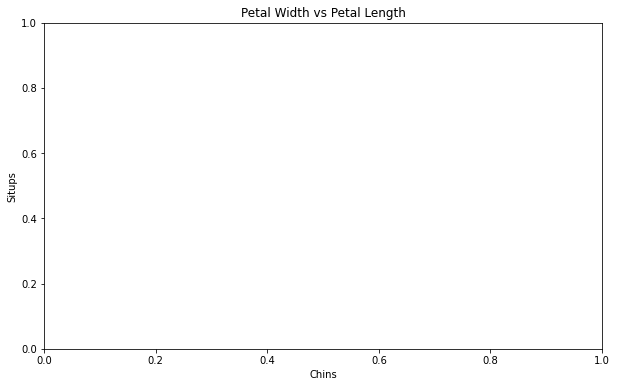

In [35]:
plt.figure(figsize = (10, 6))
colors = ['r', 'g', 'b']

plt.title('Petal Width vs Petal Length')

data = datasets.load_linnerud()
df = pd.DataFrame(data.data, columns = data.feature_names)

plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])

bucket = df.iloc[:, [0, 1]].values
up, down, all = myConvexHull(bucket)
hullDown = createListForPlot(down)
plt.scatter(hullDown[0], hullDown[1], color = colors[i])
plt.plot(hullDown[0], hullDown[1], color = colors[i])
hullUp = createListForPlot(up)
plt.scatter(hullUp[0], hullUp[1], color = colors[i])
plt.plot(hullUp[0], hullUp[1], color = colors[i])
listAll = createListForPlot(all)
plt.scatter(listAll[0], listAll[1], color = colors[i])
plt.show()